### pad_packed example

In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [2]:
from torch.nn import Embedding, LSTM
from torch.autograd import Variable

In [3]:
seqs = ['long_str',  # len = 8
        'tiny',      # len = 4
        'medium']    # len = 6

In [4]:
## Step 1: Construct Vocabulary ##

# make sure <pad> idx is 0
vocab = ['<pad>'] + sorted(set([char for seq in seqs for char in seq]))
print(vocab)

['<pad>', '_', 'd', 'e', 'g', 'i', 'l', 'm', 'n', 'o', 'r', 's', 't', 'u', 'y']


In [5]:
vectorized_seqs = [[vocab.index(tok) for tok in seq]for seq in seqs]

In [6]:
print(vectorized_seqs[0])
print(vectorized_seqs[1])
print(vectorized_seqs[2])

[6, 9, 8, 4, 1, 11, 12, 10]
[12, 5, 8, 14]
[7, 3, 2, 5, 13, 7]


In [7]:
embed = Embedding(len(vocab), 4) # embedding_dim = 4

In [8]:
lstm = LSTM(input_size=4, hidden_size=5, batch_first=True)

In [9]:
## Step 4: Pad instances with 0s  ##
seq_lengths = torch.LongTensor(list(map(len, vectorized_seqs)))
seq_tensor = Variable(torch.zeros((len(vectorized_seqs), seq_lengths.max()))).long()
for idx, (seq, seqlen) in enumerate(zip(vectorized_seqs, seq_lengths)):
    seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

In [10]:
print(seq_tensor[0])
print(seq_tensor[1])
print(seq_tensor[2])

tensor([ 6,  9,  8,  4,  1, 11, 12, 10])
tensor([12,  5,  8, 14,  0,  0,  0,  0])
tensor([ 7,  3,  2,  5, 13,  7,  0,  0])


In [11]:
## Step 5: Sort instances by sequence length
seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
seq_tensor = seq_tensor[perm_idx]

print(seq_tensor[0])
print(seq_tensor[1])
print(seq_tensor[2])

tensor([ 6,  9,  8,  4,  1, 11, 12, 10])
tensor([ 7,  3,  2,  5, 13,  7,  0,  0])
tensor([12,  5,  8, 14,  0,  0,  0,  0])


In [12]:
## Step 6: Embed the instances ##

embedded_seq_tensor = embed(seq_tensor)
print(embedded_seq_tensor.shape)

torch.Size([3, 8, 4])


```
embedded_seq_tensor =>
                      [[[-0.77578706 -1.8080667  -1.1168439   1.1059115 ]     l
                        [-0.23622951  2.0361056   0.15435742 -0.04513785]     o
                        [-0.6000342   1.1732816   0.19938554 -1.5976517 ]     n
                        [ 0.40524676  0.98665565 -0.08621677 -1.1728264 ]     g
                        [-1.6334635  -0.6100042   1.7509955  -1.931793  ]     _
                        [-0.6470658  -0.6266589  -1.7463604   1.2675372 ]     s
                        [ 0.64004815  0.45813003  0.3476034  -0.03451729]     t
                        [-0.22739866 -0.45782727 -0.6643252   0.25129375]]    r

                       [[ 0.16031227 -0.08209462 -0.16297023  0.48121014]     m
                        [-0.7303265  -0.857339    0.58913064 -1.1068314 ]     e
                        [ 0.48159844 -1.4886451   0.92639893  0.76906884]     d
                        [ 0.27616557 -1.224429   -1.342848   -0.7495876 ]     i
                        [ 0.01795524 -0.59048957 -0.53800726 -0.6611691 ]     u
                        [ 0.16031227 -0.08209462 -0.16297023  0.48121014]     m
                        [ 0.2691206  -0.43435425  0.87935454 -2.2269666 ]     <pad>
                        [ 0.2691206  -0.43435425  0.87935454 -2.2269666 ]]    <pad>

                       [[ 0.64004815  0.45813003  0.3476034  -0.03451729]     t
                        [ 0.27616557 -1.224429   -1.342848   -0.7495876 ]     i
                        [-0.6000342   1.1732816   0.19938554 -1.5976517 ]     n
                        [-1.284392    0.68294704  1.4064184  -0.42879772]     y
                        [ 0.2691206  -0.43435425  0.87935454 -2.2269666 ]     <pad>
                        [ 0.2691206  -0.43435425  0.87935454 -2.2269666 ]     <pad>
                        [ 0.2691206  -0.43435425  0.87935454 -2.2269666 ]     <pad>
                        [ 0.2691206  -0.43435425  0.87935454 -2.2269666 ]]]   <pad>
embedded_seq_tensor.shape : (batch_size X max_seq_len X embedding_dim) = (3 X 8 X 4)
```

In [13]:
packed_input = pack_padded_sequence(embedded_seq_tensor, seq_lengths.cpu().numpy(), batch_first=True)

```
packed_input (PackedSequence is NamedTuple with 2 attributes: data and batch_sizes

packed_input.data =>
                        [[-0.77578706 -1.8080667  -1.1168439   1.1059115 ]     l
                         [ 0.01795524 -0.59048957 -0.53800726 -0.6611691 ]     m
                         [-0.6470658  -0.6266589  -1.7463604   1.2675372 ]     t
                         [ 0.16031227 -0.08209462 -0.16297023  0.48121014]     o
                         [ 0.40524676  0.98665565 -0.08621677 -1.1728264 ]     e
                         [-1.284392    0.68294704  1.4064184  -0.42879772]     i
                         [ 0.64004815  0.45813003  0.3476034  -0.03451729]     n
                         [ 0.27616557 -1.224429   -1.342848   -0.7495876 ]     d
                         [ 0.64004815  0.45813003  0.3476034  -0.03451729]     n
                         [-0.23622951  2.0361056   0.15435742 -0.04513785]     g
                         [ 0.16031227 -0.08209462 -0.16297023  0.48121014]     i
                         [-0.22739866 -0.45782727 -0.6643252   0.25129375]]    y
                         [-0.7303265  -0.857339    0.58913064 -1.1068314 ]     _
                         [-1.6334635  -0.6100042   1.7509955  -1.931793  ]     u
                         [ 0.27616557 -1.224429   -1.342848   -0.7495876 ]     s
                         [-0.6000342   1.1732816   0.19938554 -1.5976517 ]     m
                         [-0.6000342   1.1732816   0.19938554 -1.5976517 ]     t
                         [ 0.48159844 -1.4886451   0.92639893  0.76906884]     r
packed_input.data.shape : (batch_sum_seq_len X embedding_dim) = (18 X 4)
```

<img src=attachment:image.png width=600>
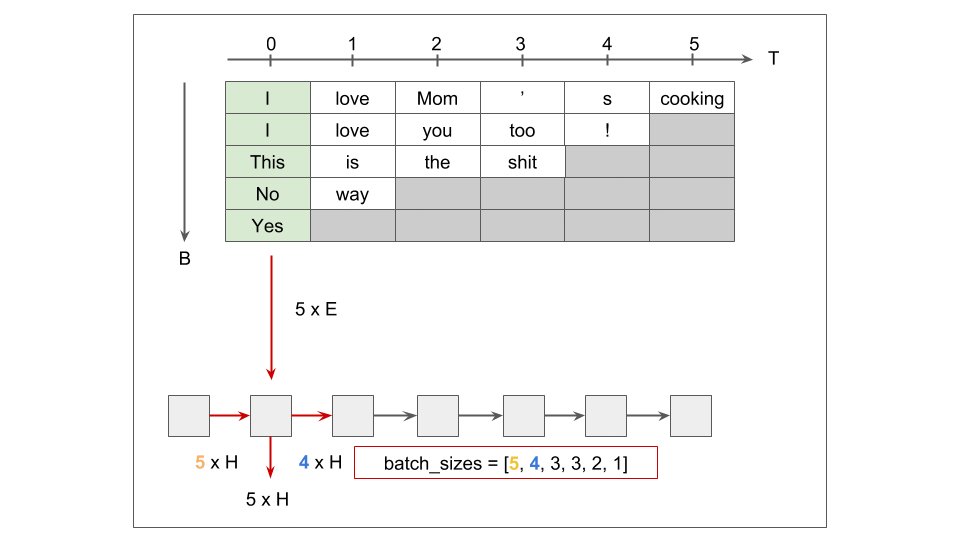

- 원래 zero padding 포함 6x5 계산했어야 한 거를 padding 제외하고 (깔끔하게) 실제 토큰 개수 18번 계산으로 해주는 것

In [14]:
packed_output, (ht, ct) = lstm(packed_input)

In [15]:
packed_output.data.shape

torch.Size([18, 5])

In [16]:
# 다시 padded 되어 있던 형태로 복귀
output, input_sizes = pad_packed_sequence(packed_output, batch_first=True)
print(output.shape)

torch.Size([3, 8, 5])
